# GS Classifier
### Attempt to differentiate events with gluon splitting from those without it

## Setup the data

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('/Users/rohan/research/gs_classifier/output_gs.csv')

feats = df.iloc[:,0:12]
y = df.isgs

In [3]:
feats.shape

(164656, 12)

In [4]:
feats.head(5)

,weight,dr_bb,bb_pt,bb_m,jet1_csv,jet1_pt,jet1_eta,jet1_phi,jet2_csv,jet2_pt,jet2_eta,jet2_phi
0,0.068587,0.947933,806.513000,418.969666,0.970258,469.232178,-1.552434,0.988524,0.906826,340.613373,-0.622500,1.172366
1,0.065783,1.710818,345.106720,202.336594,0.993821,47.740227,1.110587,-1.902524,0.958397,346.806488,0.763946,-0.227192
2,0.069150,0.821434,699.727417,307.803986,0.996421,344.196381,0.981522,-0.860860,0.901411,418.045929,1.034307,-0.041124
3,0.069805,1.968648,235.376617,302.447571,0.987000,153.347351,0.517652,0.096551,0.862928,140.702484,-0.972188,1.383389
4,0.068559,1.061551,743.231018,418.841614,0.907696,374.111206,0.631812,1.520363,0.853196,370.016937,-0.425185,1.618583


In [5]:
y.shape

(164656,)

In [6]:
y.head(5)

0    1
1    1
2    0
3    1
4    0
Name: isgs, dtype: int64

#### Use K-folds for cross-validation

In [8]:
from sklearn.model_selection import KFold
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=452)

## Decision Tree
#### Loop over the folds, train, and evaluate the decision tree

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
tree = DecisionTreeClassifier()
train_scores = []
test_scores = []
for idx, (train, test) in enumerate(kf.split(feats, y)):
    # Setup weights and train/test sets
    train_weights = list(feats.iloc[train,0])
    X_train, y_train = feats.iloc[train,1:12], y.iloc[train]
    test_weights = list(feats.iloc[test,0])
    X_test, y_test = feats.iloc[test, 1:12], y.iloc[test]

    # Train tree
    tree.fit(X_train, y_train, sample_weight=train_weights)
    
    # Evaluate
    print("Fold {}:").format(idx+1)
    train_scores.append(roc_auc_score(y_train, tree.predict(X_train), sample_weight=train_weights))
    print("Train score: {:.3f}").format(train_scores[idx])
    test_scores.append(roc_auc_score(y_test, tree.predict(X_test), sample_weight=test_weights))
    print("Test score: {:.3f}\n").format(test_scores[idx])
    
print("Mean train score: {:.3f}").format(sum(train_scores)/n_folds)
print("Mean test score: {:.3f}").format(sum(test_scores)/n_folds)    

Fold 1:
Train score: 1.000
Test score: 0.559

Fold 2:
Train score: 1.000
Test score: 0.554

Fold 3:
Train score: 1.000
Test score: 0.561

Fold 4:
Train score: 1.000
Test score: 0.558

Fold 5:
Train score: 1.000
Test score: 0.553

Mean train score: 1.000
Mean test score: 0.557


In [11]:
### Confusion matrix for fold 5
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, tree.predict(X_test), sample_weight=test_weights)
print("Confusion matrix")
print(cm)
print("Normalized confusion matrix")
print(cm.astype('float')/cm.sum(axis=1)[:, np.newaxis])

Confusion matrix
[[ 81.80483019  65.03153561]
 [ 59.68257544  72.60793032]]
Normalized confusion matrix
[[ 0.5571156   0.4428844 ]
 [ 0.45114784  0.54885216]]


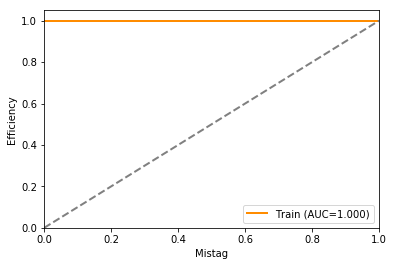

In [51]:
# Training ROC
plot_roc([y_train], [tree.predict(X_train)], 1, [train_weights])

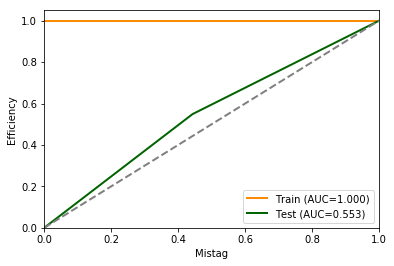

In [52]:
# Train and Test ROC
plot_roc([y_train, y_test], [tree.predict(X_train), tree.predict(X_test)], 1, [train_weights, test_weights])

# Matrix labels, x-axis (left to right) predicted !gs/gs, y-axis (top to bottom) truth !gs/gs

### Try limiting max depth

In [56]:
for depth in range(1,15):
    print("Depth {}").format(depth)
    tree_depth = DecisionTreeClassifier(max_depth=depth)
    train_scores = []
    test_scores = []
    for idx, (train, test) in enumerate(kf.split(feats, y)):
        # Setup weights and train/test sets
        train_weights = list(feats.iloc[train,0])
        X_train, y_train = feats.iloc[train,1:12], y.iloc[train]
        test_weights = list(feats.iloc[test,0])
        X_test, y_test = feats.iloc[test, 1:12], y.iloc[test]

        # Train tree
        tree_depth.fit(X_train, y_train, sample_weight=train_weights)
    
        # Evaluate
        train_scores.append(roc_auc_score(y_train, tree_depth.predict(X_train), sample_weight=train_weights))
        test_scores.append(roc_auc_score(y_test, tree_depth.predict(X_test), sample_weight=test_weights))
    
    print("\tMean train score: {:.3f}").format(sum(train_scores)/n_folds)
    print("\tMean test score: {:.3f}").format(sum(test_scores)/n_folds)
    
    if depth==6: 
        print("\n\tFeature Importance:")
        print(tree_depth.feature_importances_)

Depth 1
	Mean train score: 0.629
	Mean test score: 0.628
Depth 2
	Mean train score: 0.629
	Mean test score: 0.628
Depth 3
	Mean train score: 0.628
	Mean test score: 0.626
Depth 4
	Mean train score: 0.631
	Mean test score: 0.628
Depth 5
	Mean train score: 0.638
	Mean test score: 0.632
Depth 6
	Mean train score: 0.642
	Mean test score: 0.633

	Feature Importance:
[ 0.06592732  0.05562635  0.0320795   0.74388791  0.0297635   0.01338757
  0.00081525  0.03824978  0.00430773  0.01517651  0.00077857]
Depth 7
	Mean train score: 0.647
	Mean test score: 0.631
Depth 8
	Mean train score: 0.657
	Mean test score: 0.630
Depth 9
	Mean train score: 0.667
	Mean test score: 0.627
Depth 10
	Mean train score: 0.677
	Mean test score: 0.624
Depth 11
	Mean train score: 0.692
	Mean test score: 0.622
Depth 12
	Mean train score: 0.709
	Mean test score: 0.618
Depth 13
	Mean train score: 0.727
	Mean test score: 0.614
Depth 14
	Mean train score: 0.748
	Mean test score: 0.611


In [ ]:
# Use depth = 9, as it is just beyond overfitting

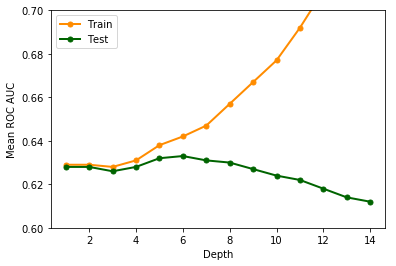

In [75]:
#Train scores
train_scores = [0.629, 0.629, 0.628, 0.631, 0.638, 0.642, 0.647, 0.657, 0.667, 0.677, 0.692, 0.709, 0.727, 0.748]
#Test scores
test_scores = [0.628, 0.628, 0.626, 0.628, 0.632, 0.633, 0.631, 0.630, 0.627, 0.624, 0.622, 0.618, 0.614, 0.612]

# Plot train/test scores as a function of depth
plt.plot(range(1,15), train_scores, color='darkorange', label = 'Train', lw=2, marker='.', ms=10)
plt.plot(range(1,15), test_scores, color='darkgreen', label = 'Test', lw=2, marker='.', ms=10)
plt.ylim([0.6, 0.7])
plt.xlabel('Depth')
plt.ylabel('Mean ROC AUC')
plt.legend(loc='upper left')
plt.show()

# Add limits on min_samples_leaf

In [153]:
for leaf in range(1500,1501):
    print("Leaf(s) {}").format(leaf)
    tree_leaf = DecisionTreeClassifier(max_depth=9, min_samples_leaf=leaf)
    train_scores = []
    test_scores = []
    for idx, (train, test) in enumerate(kf.split(X, y)):
        # Setup weights and train/test sets
        train_weights = list(feats.iloc[train,0])
        X_train, y_train = feats.iloc[train,1:12], y.iloc[train]
        test_weights = list(feats.iloc[test,0])
        X_test, y_test = feats.iloc[test, 1:12], y.iloc[test]

        # Train tree
        tree_leaf.fit(X_train, y_train, sample_weight=train_weights)
    
        # Evaluate
        train_scores.append(roc_auc_score(y_train, tree_leaf.predict(X_train), sample_weight=train_weights))
        test_scores.append(roc_auc_score(y_test, tree_leaf.predict(X_test), sample_weight=test_weights))
    
    print("\tMean train score: {:.3f}").format(sum(train_scores)/n_folds)
    print("\tMean test score: {:.3f}").format(sum(test_scores)/n_folds)

Leaf(s) 1500
	Mean train score: 0.640
	Mean test score: 0.632


In [ ]:
# Doesn't add much over max_depth so don't use. Instead use max_depth = 6

### Add limit on max_features

In [171]:
for feat in range(1,12):
    print("Feats {}").format(feat)
    tree_feat = DecisionTreeClassifier(max_depth=6, max_features=feat)
    train_scores = []
    test_scores = []
    for idx, (train, test) in enumerate(kf.split(X, y)):
        # Setup weights and train/test sets
        train_weights = list(feats.iloc[train,0])
        X_train, y_train = feats.iloc[train,1:12], y.iloc[train]
        test_weights = list(feats.iloc[test,0])
        X_test, y_test = feats.iloc[test, 1:12], y.iloc[test]

        # Train tree
        tree_feat.fit(X_train, y_train, sample_weight=train_weights)
    
        # Evaluate
        train_scores.append(roc_auc_score(y_train, tree_feat.predict(X_train), sample_weight=train_weights))
        test_scores.append(roc_auc_score(y_test, tree_feat.predict(X_test), sample_weight=test_weights))
        
    print("\tMean train score: {:.3f}").format(sum(train_scores)/n_folds)
    print("\tMean test score: {:.3f}").format(sum(test_scores)/n_folds)
    
    if feat==7: 
        print("\n\tFeature Importance:")
        print(tree_feat.feature_importances_)

Feats 1
	Mean train score: 0.601
	Mean test score: 0.595
Feats 2
	Mean train score: 0.622
	Mean test score: 0.613
Feats 3
	Mean train score: 0.634
	Mean test score: 0.625
Feats 4
	Mean train score: 0.636
	Mean test score: 0.628
Feats 5
	Mean train score: 0.640
	Mean test score: 0.632
Feats 6
	Mean train score: 0.640
	Mean test score: 0.630
Feats 7
	Mean train score: 0.642
	Mean test score: 0.634

	Feature Importance:
[ 0.06494601  0.05799704  0.02081478  0.73533646  0.026564    0.03462659
  0.00169229  0.03867981  0.00924843  0.00476484  0.00532977]


Feats 8
	Mean train score: 0.641
	Mean test score: 0.632
Feats 9
	Mean train score: 0.640
	Mean test score: 0.631
Feats 10
	Mean train score: 0.642
	Mean test score: 0.634
Feats 11
	Mean train score: 0.642
	Mean test score: 0.633


In [172]:
# The most useful discriminator is surprisingly the highest csv of the b-jets in the event

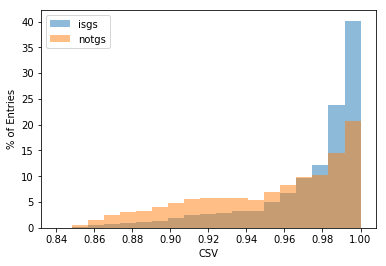

In [78]:
bins = np.linspace(0.84,1.00,20)
plt.hist(df[df.isgs==1].jet1_csv, bins, alpha=0.5, label='isgs', normed=True)
plt.hist(df[df.isgs==0].jet1_csv, bins, alpha=0.5, label='notgs', normed=True)
plt.xlabel('CSV')
plt.ylabel('% of Entries')
plt.legend(loc='upper left')
plt.show()

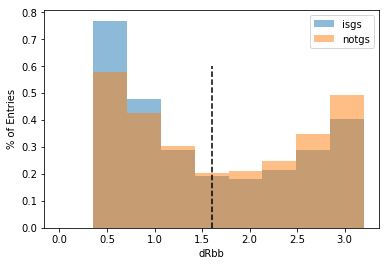

In [19]:
bins = np.linspace(0,3.2,10)
plt.hist(df[df.isgs==1].dr_bb, bins, alpha=0.5, label='isgs', normed=True)
plt.hist(df[df.isgs==0].dr_bb, bins, alpha=0.5, label='notgs', normed=True)
plt.plot([1.6,1.6],[0,0.6], color='black', linestyle='--')
plt.xlabel('dRbb')
plt.ylabel('% of Entries')
plt.legend(loc='upper right')
plt.show()

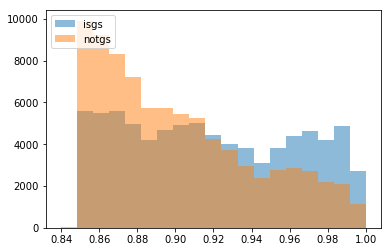

In [184]:
bins = np.linspace(0.84,1.00,20)
plt.hist(df[df.isgs==1].jet2_csv, bins, alpha=0.5, label='isgs')
plt.hist(df[df.isgs==0].jet2_csv, bins, alpha=0.5, label='notgs')
plt.legend(loc='upper left')
plt.show()

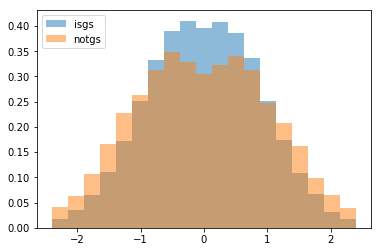

In [8]:
bins = np.linspace(-2.4,2.4,20)
plt.hist(df[df.isgs==1].jet1_eta, bins, alpha=0.5, label='isgs', normed=True)
plt.hist(df[df.isgs==0].jet1_eta, bins, alpha=0.5, label='notgs', normed=True)
plt.legend(loc='upper left')
plt.show()

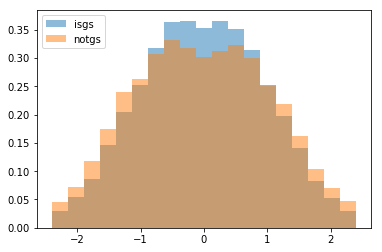

In [9]:
bins = np.linspace(-2.4,2.4,20)
plt.hist(df[df.isgs==1].jet2_eta, bins, alpha=0.5, label='isgs', normed=True)
plt.hist(df[df.isgs==0].jet2_eta, bins, alpha=0.5, label='notgs', normed=True)
plt.legend(loc='upper left')
plt.show()

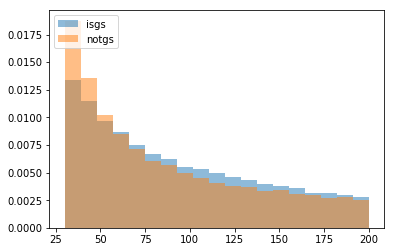

In [11]:
bins = np.linspace(30,200,20)
plt.hist(df[df.isgs==1].jet1_pt, bins, alpha=0.5, label='isgs', normed=True)
plt.hist(df[df.isgs==0].jet1_pt, bins, alpha=0.5, label='notgs', normed=True)
plt.legend(loc='upper left')
plt.show()

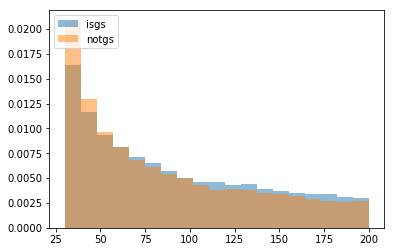

In [12]:
bins = np.linspace(30,200,20)
plt.hist(df[df.isgs==1].jet2_pt, bins, alpha=0.5, label='isgs', normed=True)
plt.hist(df[df.isgs==0].jet2_pt, bins, alpha=0.5, label='notgs', normed=True)
plt.legend(loc='upper left')
plt.show()

## Conclusion 

### In order to reduce the importance on one feature (i.e. the highest csv), there are two options to try.

### 1) Proceed to a random forest

### 2) Try classifier not just isgs vs notgs, but what type of gs, since they have different signatures and different features may be important for each

In [50]:
from sklearn.metrics import roc_curve
## PLOT ROC CURVE
def plot_roc(y_true, y_score, pos_label, sample_weight):
    colors = ['darkorange','darkgreen']
    labels = ['Train','Test']
    for iplt in range(len(y_true)):
        fpr, tpr, _ = roc_curve(y_true[iplt], y_score[iplt], pos_label, sample_weight[iplt])
        plt.plot(fpr, tpr, color=colors[iplt], lw=2, label='{} (AUC={:.3f})'.format(labels[iplt], roc_auc_score(y_true[iplt], y_score[iplt], sample_weight=sample_weight[iplt])))
    plt.plot([0,1], [0,1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Mistag')
    plt.ylabel('Efficiency')
    plt.legend(loc='lower right')
    plt.show()

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
### GET SCORES IN TERMS OF ACCURACY
for depth in range(1,15):
    print("Depth {}").format(depth)
    tree_depth = DecisionTreeClassifier(max_depth=depth)
    train_scores = []
    test_scores = []
    for idx, (train, test) in enumerate(kf.split(feats, y)):
        # Setup weights and train/test sets
        train_weights = list(feats.iloc[train,0])
        X_train, y_train = feats.iloc[train,1:12], y.iloc[train]
        test_weights = list(feats.iloc[test,0])
        X_test, y_test = feats.iloc[test, 1:12], y.iloc[test]

        # Train tree
        tree_depth.fit(X_train, y_train, sample_weight=train_weights)
    
        # Evaluate
        train_scores.append(accuracy_score(y_train, tree_depth.predict(X_train), sample_weight=train_weights))
        test_scores.append(accuracy_score(y_test, tree_depth.predict(X_test), sample_weight=test_weights))
    
    print("\tMean train score: {:.3f}").format(sum(train_scores)/n_folds)
    print("\tMean test score: {:.3f}").format(sum(test_scores)/n_folds)
    
    if depth==6: 
        print("\n\tFeature Importance:")
        print(tree_depth.feature_importances_)

Depth 1
	Mean train score: 0.626
	Mean test score: 0.625
Depth 2
	Mean train score: 0.626
	Mean test score: 0.625
Depth 3
	Mean train score: 0.631
	Mean test score: 0.628
Depth 4
	Mean train score: 0.633
	Mean test score: 0.630
Depth 5
	Mean train score: 0.637
	Mean test score: 0.630
Depth 6
	Mean train score: 0.642
	Mean test score: 0.633

	Feature Importance:
[ 0.06592732  0.05562635  0.0320795   0.74388791  0.0297635   0.01338757
  0.00081525  0.03824978  0.00430773  0.01517651  0.00077857]
Depth 7
	Mean train score: 0.648
	Mean test score: 0.632
Depth 8
	Mean train score: 0.657
	Mean test score: 0.630
Depth 9
	Mean train score: 0.667
	Mean test score: 0.627
Depth 10
	Mean train score: 0.678
	Mean test score: 0.624
Depth 11
	Mean train score: 0.693
	Mean test score: 0.622
Depth 12
	Mean train score: 0.710
	Mean test score: 0.619
Depth 13
	Mean train score: 0.728
	Mean test score: 0.614
Depth 14
	Mean train score: 0.748
	Mean test score: 0.612
